In [1]:
import h5py
import glob
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from alvra_tools.load_data import *
from alvra_tools.channels import *
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf
from ipyfilechooser import FileChooser
from IPython.display import clear_output, display
%matplotlib nbagg

In [2]:
lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

p0 = 1024   
px2fs = 1.993008440575784 # new spectrometer, it is ~ 2 px to fs


In [3]:
background_from_fit = np.loadtxt('/sf/alvra/data/p18386/scratch/2020-10-20-10:45-psen-background.txt')

# choose the data file(s):
datafiles = []
for file in glob('/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/*.BSREAD.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
datafiles

['/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000957.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000958.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000959.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000960.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000961.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000962.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000964.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000965.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000966.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000967.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000968.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000963.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000969.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000970.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000971.BSREAD.

In [5]:
Timezero_loop = 176.37489

channel_list_pp = [channel_Events, channel_PSEN_signal, channel_PSEN_bkg, channel_delay_topas, channel_Izero117]
channel_list_all = channel_list_pp

###################################################################################################

import itertools

run_number = []
pid_number = []
Delays_stage_fs = []
edgePos = []
edgePosRun = []
sigtraces = []
peaktraces =[]
peakAmp = []

for fileName in datafiles[:1]:
#    clear_output(wait=True)
    print ("Processing file {}". format(fileName))
    run_number.append(int(fileName.split('_')[-1].split('.')[0]))
    print ("File {}/{}".format(len(run_number),len(datafiles)))
    
    resultsPP, results, pids_pump, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, fileName)
    
#    pid_number.append(pids_pump[0])
    
    sig = resultsPP[channel_PSEN_signal].pump
    back = resultsPP[channel_PSEN_bkg].pump
    delay_shot = resultsPP[channel_delay_topas].pump
    Izero = resultsPP[channel_Izero117].pump
    
    print (np.shape(sig), np.shape(back))
    
    delay_shot_fs = (delay_shot - Timezero_loop)*2/(3e8*1e3*1e-15)
    
#    Delays_stage.append(delayTopas_fs)
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        
        sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, 50)
        sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
        sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
        
        peak2 = np.argmax(sig5gaussO1)
        peakAmp.append(np.max(sig5gaussO1))
        
        #if (peak2.max() > 0.05): 
        edgePos.append(peak2)
        sigtraces.append(sig6)
        peaktraces.append(sig5gaussO1)

        Delays_stage_fs.append(np.round(np.mean(delay_shot_fs),4))
        #edgeSig.append(sig5)
    
    edgePosRun.append(np.array(np.nanmean(edgePos)))

Delays_corr = Delays_stage_fs + ((p0 - np.array(edgePos))*px2fs)


    

Processing file /sf/alvra/data/p18386/raw/mbco_10ps_400nJ/run_000957.BSREAD.h5
File 1/86

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile  999 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile      999 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY                    945 / 1000 -> 6% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 944 / 1000 -> 6% loss
complete channels: 2 / 5 -> 60% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 944 pump and 0 unpump shots
(944, 2047) (944, 2047)


In [32]:
peakAmp_norm = peakAmp / Izero
len(peakAmp_norm)

944

<IPython.core.display.Javascript object>


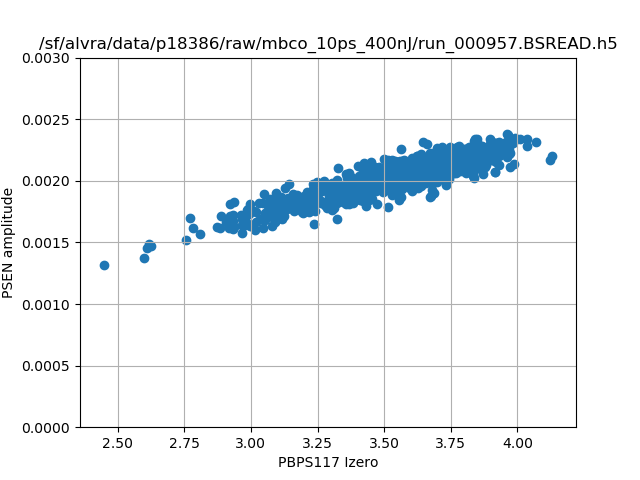

In [29]:
plt.figure()
plt.title(datafiles[0])
plt.scatter(Izero, peakAmp)
plt.ylim(0, 0.003)
plt.xlabel('PBPS117 Izero')
plt.ylabel('PSEN amplitude')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


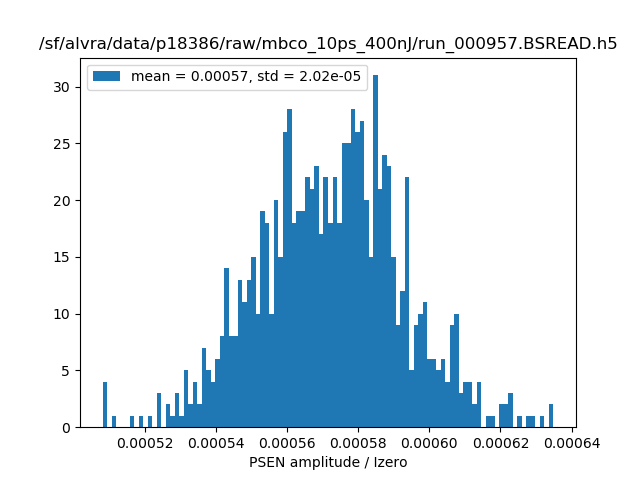

In [30]:
plt.figure()
plt.title(datafiles[0])

plt.hist(peakAmp_norm, bins=100, label = 'mean = {}, std = {}'.format(np.round(peakAmp_norm.mean(),5), np.round(peakAmp_norm.std(),7)))
plt.legend(loc='best')
plt.xlabel('PSEN amplitude / Izero')
plt.show()

In [18]:
run_number_all = run_number.copy()
pid_number_all = pid_number.copy()
edgePosRun_all = edgePosRun.copy()
edgePos_all = edgePos.copy()
Delays_stage_all = Delays_stage.copy()
Delays_corr_all = Delays_corr.copy()

<IPython.core.display.Javascript object>


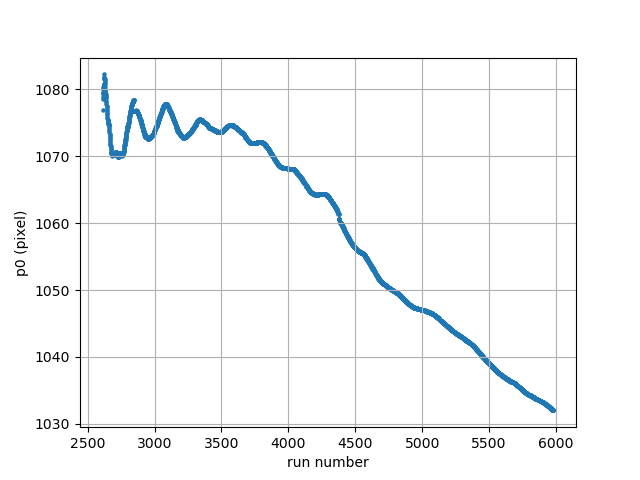

In [19]:
plt.figure()
#plt.plot(run_number_start, edgePosRun_start)
#plt.plot(run_number_end, edgePosRun_end)

#plt.scatter(run_number_start, edgePosRun_start, s=5)
#plt.scatter(run_number_middle, edgePosRun_middle, s=5)
#plt.scatter(run_number_end, edgePosRun_end, s=5)
plt.scatter(run_number_all, edgePosRun_all, s=5)

plt.xlabel('run number')
plt.ylabel('p0 (pixel)')
plt.grid()
plt.show()

In [22]:
print (np.shape(Delays_stage), np.shape(edgePos))
#Delays_corr = Delays_stage[:363526] + ((p0 - np.array(edgePos))*px2fs)

(0,) (0,)


In [23]:
np.mean(Delays_stage_all)

79.79886227129886

<IPython.core.display.Javascript object>


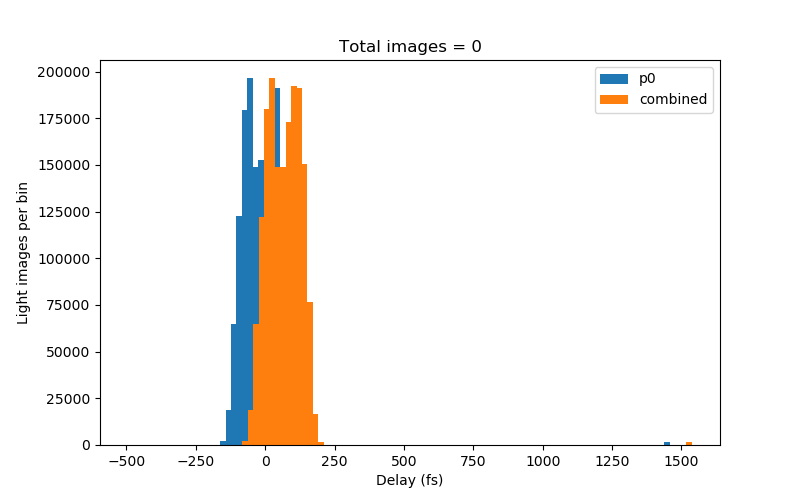

In [24]:
plt.figure(figsize=(8,5))
plt.title('Total images = {}'.format(len(edgePos)))

plt.hist((p0 - np.array(edgePos_all))*px2fs, bins=100, label = 'p0')
plt.hist(Delays_corr_all, bins=100, label = 'combined')
#plt.hist(Delays_stage_all, bins=10)
plt.legend (loc='best')
plt.xlabel('Delay (fs)')
plt.ylabel('Light images per bin')
plt.show()

In [ ]:
np.shape(edgePos)

In [ ]:
for file in datafiles:
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]

In [ ]:
back_avg = np.mean(back, axis=0)
sig_avg = np.mean(sig, axis=0)
background_avg = sig_avg/back_avg

# polyfit a smooth background...
def polyfxn(x, a, b, c, d, e, f, g, h):
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h

fitParams, _ = optimize.curve_fit(polyfxn, lambdas[400:2047], background_avg[400:2047], p0=[1, 1, 1, 1, 1, 1, 1, 1])

background_from_fit = polyfxn(lambdas[400:2047], *fitParams)


plt.figure()
#plt.plot(back_avg)
#plt.plot(sig_avg)
plt.plot(background_avg[400:2047])
plt.plot(background_from_fit)
plt.plot(background_avg[400:2047]/background_from_fit)
plt.show()


In [ ]:
fitParams

In [27]:
#plt.figure()
#plt.plot(background_from_fit)
#plt.show()
#background_from_fit

#np.savetxt('/sf/alvra/data/p18647/scratch/2020-09-03-23:30-psen-background.txt', background_from_fit)

In [3]:
background_from_fit = np.loadtxt('/sf/alvra/data/p18647/scratch/2020-09-18-13:40-psen-background.txt')

fc = FileChooser('/sf/alvra/data/p18647/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18647/raw/scan_info', filename='', show_hidden='False')

In [20]:

channel_list_pp = [channel_Events, channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp

json_file = fc.selected

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
stagePos = np.array(data['scan_readbacks'])

Timezero = stagePos[0] + (stagePos[-1] - stagePos[0]) / 2

#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

timingMean = []
timingStd = []
#stagePos = 
edgeSigMean = []


for i in range(0,numFiles):
    clear_output(wait=True)
    filename = (data['scan_files'][i])
    resultsPP, results = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filename[0])
    
    sig = resultsPP[channel_PSEN_signal].pump
    back = resultsPP[channel_PSEN_bkg].pump
    
    edgePos = [] # edge positions
    edgeSig = []
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
#        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
#        sig5 = sig4inter(nus)
        sig4savgol = savgol_filter(sig4invreal[0:1647], 201, 1)
        sig5 = sig4savgol
        
        # cross correlation, isolate the peak, save it if we have no division by zero errors
        xcorr2 = np.correlate(sig5, filter3, 'same')
        peak2 = savgol_filter(np.diff(xcorr2)[250:1647-250], 201, 3)
        peakxcorr, _ = find_peaks(peak2[:],height=np.max(peak2[:]))
        if (peakxcorr > 0) & (peak2.max() > 0.05): 
            edgePos.append(peakxcorr[0])
        edgeSig.append(sig5)
    
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))
    
Delay_fs = (stagePos - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !
    


--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     500 / 500 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 265 / 500 -> 47% loss ▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     265 / 500 -> 47% loss ▇▇▇▇▇

over the whole data set: 265 / 500 -> 47% loss

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 265 pump and 0 unpump shots
163.69480519480518
15.827121191858968


<IPython.core.display.Javascript object>


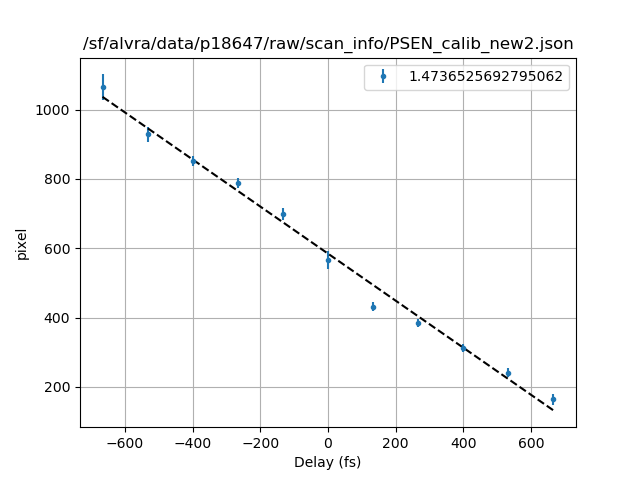

1.4736525692795062


In [21]:
m,b = np.polyfit(Delay_fs.T[0],timingMean, 1) 

plt.figure()
plt.title(fc.selected)
plt.plot (Delay_fs, m*Delay_fs + b,  '--', color='black')
plt.errorbar(Delay_fs, timingMean, yerr = timingStd, fmt='.',label = str(-1/m))
plt.legend(loc='best')
plt.xlabel('Delay (fs)')
plt.ylabel('pixel')
plt.grid()
plt.show()

print(-1/m)


In [16]:
# choose the data file(s):
datafiles = []
for file in glob.glob('/sf/alvra/data/p18647/raw/PSEN_calib_new/*.BSREAD.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)

background_from_fit = np.loadtxt('/sf/alvra/data/p18647/scratch/2020-09-18-12:05-psen-background.txt')

datafiles[1:]

['/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002770.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002771.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002772.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002773.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002774.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002775.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002776.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002777.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002778.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002779.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002780.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002781.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002782.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002783.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002784.BSREAD.h5',
 '/sf/alvr

In [17]:
timingMean = []
timingStd = []
stagePos = []
edgeSigMean = []

for file in datafiles[1:]:
    print(file)
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
        #globalGlobi = f['/data/SLAAR11-LMOT-M452:ENC_1_BS/data'][:]
        #laser_diode = f['data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data'][:]

    # logic for whether we start on a delayed shot or not
    #if events[0, 21].astype(bool) == True:
    #    start = 0
    #else:
    #    start = 2

    edgePos = [] # edge positions
    edgeSig = []

    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
#        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
#        sig5 = sig4inter(nus)
        sig4savgol = savgol_filter(sig4invreal[0:1647], 201, 1)
        sig5 = sig4savgol
        
        # cross correlation, isolate the peak, save it if we have no division by zero errors
        xcorr2 = np.correlate(sig5, filter3, 'same')
        peak2 = savgol_filter(np.diff(xcorr2)[250:1647-250], 201, 3)
        peakxcorr, _ = find_peaks(peak2[:],height=np.max(peak2[:]))
        if (peakxcorr > 0) & (peak2.max() > 0.05): 
            edgePos.append(peakxcorr[0])
        edgeSig.append(sig5)
            
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))
    #stagePos.append(globalGlobi)

/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002770.BSREAD.h5
289.3666666666667
44.141049174461436
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002771.BSREAD.h5
199.62995594713655
20.098536591647974
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002772.BSREAD.h5


/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


195.7
15.969032531747187
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002773.BSREAD.h5
171.3969465648855
14.336564787743793
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002774.BSREAD.h5
190.53821656050957
121.41795008642161
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002775.BSREAD.h5
627.6495468277946
299.64911679272257
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002776.BSREAD.h5
595.413407821229
256.9615475420445
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002777.BSREAD.h5
186.32716049382717
15.439779570051272
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002778.BSREAD.h5
170.35
11.96985797743649
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002779.BSREAD.h5
160.4512195121951
26.558947678039175
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002780.BSREAD.h5
172.6983606557377
15.205720362376125
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002781.BSREAD.h5
152.6813627254509
11.419171085646274
/sf/alvra/data/p18647/raw/PSEN_calib_new/run_002782.BSREAD.h5
164.34549878345499
28.959949656700

In [18]:
xaxis = 86.72679*np.arange(0,11)
xaxis -= np.mean(xaxis)

def straightLine(x, a, b):
    return a*x + b

fitParams_lines, _ = optimize.curve_fit(straightLine, xaxis, timingMean, p0=[1, 550])
psen_calib_from_fit = straightLine(xaxis, *fitParams_lines)
print(fitParams_lines)

plt.figure(figsize=(5,4))
plt.title('PSEN_calib4')
#plt.plot(xaxis, timingMean)
plt.plot(xaxis, psen_calib_from_fit, '--', color='black')
plt.errorbar(xaxis, timingMean, yerr=timingStd, fmt='.', )
plt.xlabel('time, fs')
plt.ylabel('edge position, px')
plt.show()
print(-1/fitParams_lines[0])

ValueError: operands could not be broadcast together with shapes (11,) (19,) 

In [180]:
timingMean = []
timingStd = []
stagePos = []
edgeSigMean = []
edgeAmp = []

for file in datafiles:
    print(file)
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]

    edgePos = [] # edge positions
    edgeSig = []

    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, et cetera
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
        sig5 = sig4inter(nus)
#        sig5 = sig4invreal
        sig5gaussO0 = gaussian_filter1d(sig5, 95) # gaussian filtering with sigma = 66px
        sig5gaussO1 = gaussian_filter1d(sig5, 95, order=1) # gaussian derivative filter to recover the peak
        if sig5gaussO1.max() > 0.00035:
            edgePos.append(np.argmax(sig5gaussO1))
        edgeSig.append(sig5gaussO0)
        edgeAmp.append(np.max(sig5gaussO1))
            
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))
    #stagePos.append(globalGlobi)

/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000309.BSREAD.h5
1021.20625
18.480878702165832
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000311.BSREAD.h5
952.5
19.58432684541814
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000313.BSREAD.h5
876.0961098398169
23.383185659664562
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000315.BSREAD.h5
808.6935866983373
18.426039658371778
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000318.BSREAD.h5
733.0229166666667
13.679877856169703
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000320.BSREAD.h5
691.1327967806841
12.043619198786633
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000322.BSREAD.h5
645.642
10.455708297384735
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000324.BSREAD.h5
602.724
10.667887513467697
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000326.BSREAD.h5
557.664
10.581072913462037
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000329.BSREAD.h5
515.3
11.479634140511623
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000331.BSREAD.h5
466.34
11.938525872150214


[-6.26601776e-01  7.15483787e+02]


<IPython.core.display.Javascript object>


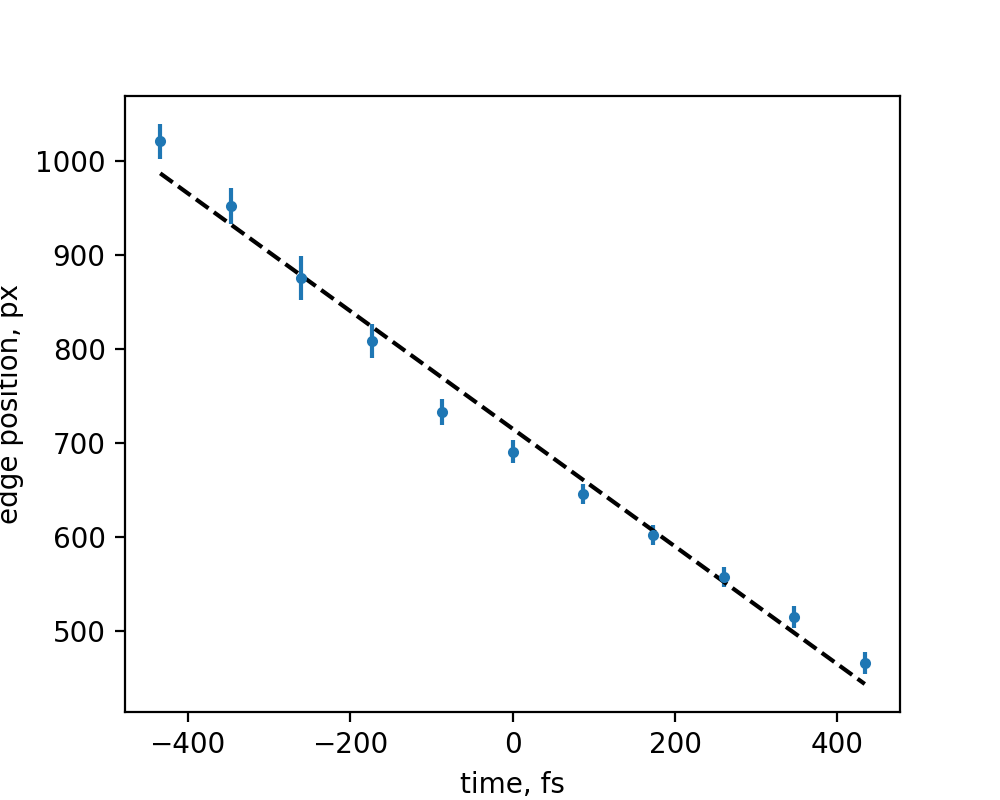

1.5959099365182228


In [181]:
xaxis = 86.72679*np.arange(0,11)
xaxis -= np.mean(xaxis)

def straightLine(x, a, b):
    return a*x + b

fitParams_lines, _ = optimize.curve_fit(straightLine, xaxis, timingMean, p0=[1, 550])
psen_calib_from_fit = straightLine(xaxis, *fitParams_lines)
print(fitParams_lines)

plt.figure(figsize=(5,4))
#plt.plot(xaxis, timingMean)
plt.plot(xaxis, psen_calib_from_fit, '--', color='black')
plt.errorbar(xaxis, timingMean, yerr=timingStd, fmt='.', )
plt.xlabel('time, fs')
plt.ylabel('edge position, px')
plt.show()
print(-1/fitParams_lines[0])

In [167]:
timingMean = []
timingStd = []
edgeSigMean = []

file = '/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000322.BSREAD.h5'
    # Load spectral data and spectrometer calibration
with h5py.File(file, 'r') as f:
    events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
    back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
    sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]

edgePos = [] # edge positions
edgeSig = []
edgeAmp = [] # amplitudes

for sigma in range(10, 200, 20):

    edgePos = [] # edge positions
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, et cetera
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, sigma) # gaussian filtering with sigma = 66px
        sig5gaussO1 = gaussian_filter1d(sig5, sigma, order=1) # gaussian derivative filter to recover the peak
        if sig5gaussO1.max() > 0.00022:
            edgePos.append(np.argmax(sig5gaussO1))
        edgeSig.append(sig5gaussO0)
        edgeAmp.append(sig5gaussO1.max())
            
    print(sigma)
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))

10
9.0
0.0
30
630.024
13.37951508837297
50
642.562
11.498789327577056
70
646.274
10.676091232281598
90
645.99
10.495232250884207
110
644.082
10.588450122657235
130
641.244
11.099029867515448
150
637.76
11.977579054216259
170
633.843373493976
13.213096151344656
190
629.76875
14.72040330417275


<IPython.core.display.Javascript object>


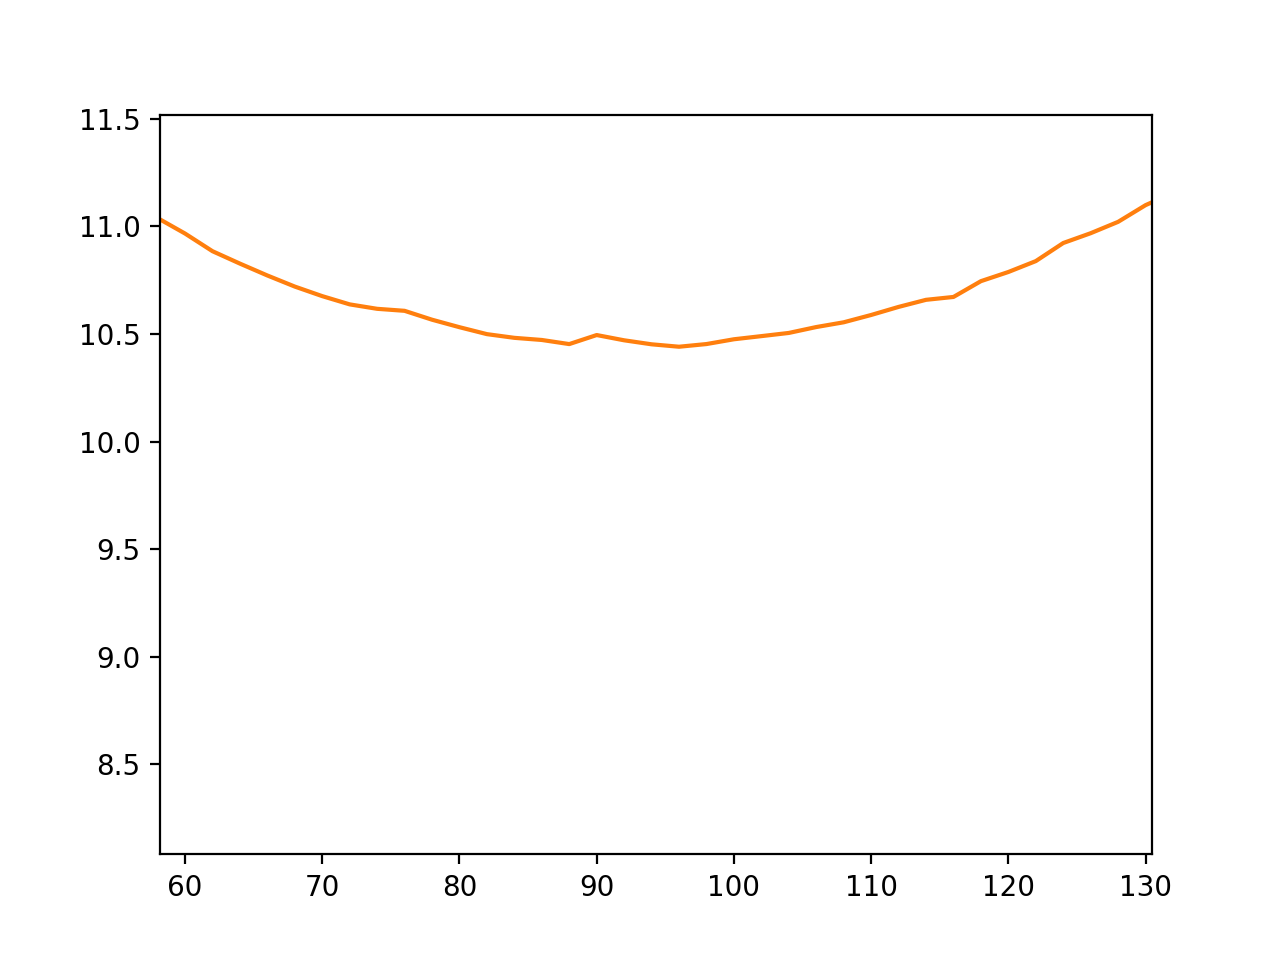

In [149]:
sigmas = np.arange(10, 200, 2)
plt.figure()
plt.plot(sigmas, timingMean)
plt.plot(sigmas, timingStd)
#plt.plot(edgePos)

<IPython.core.display.Javascript object>


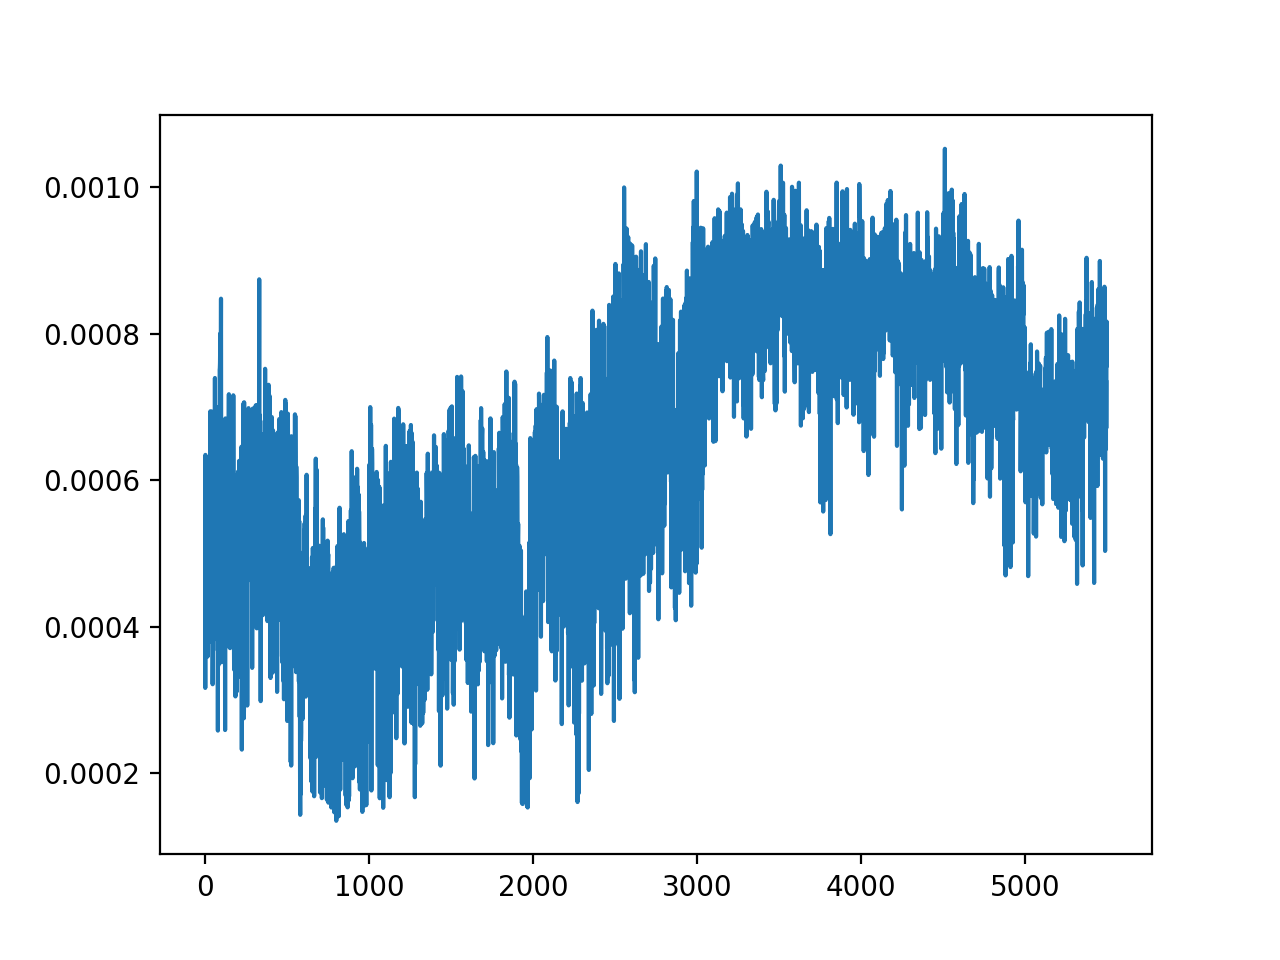

In [182]:
plt.figure()
plt.plot(edgeAmp)

<IPython.core.display.Javascript object>


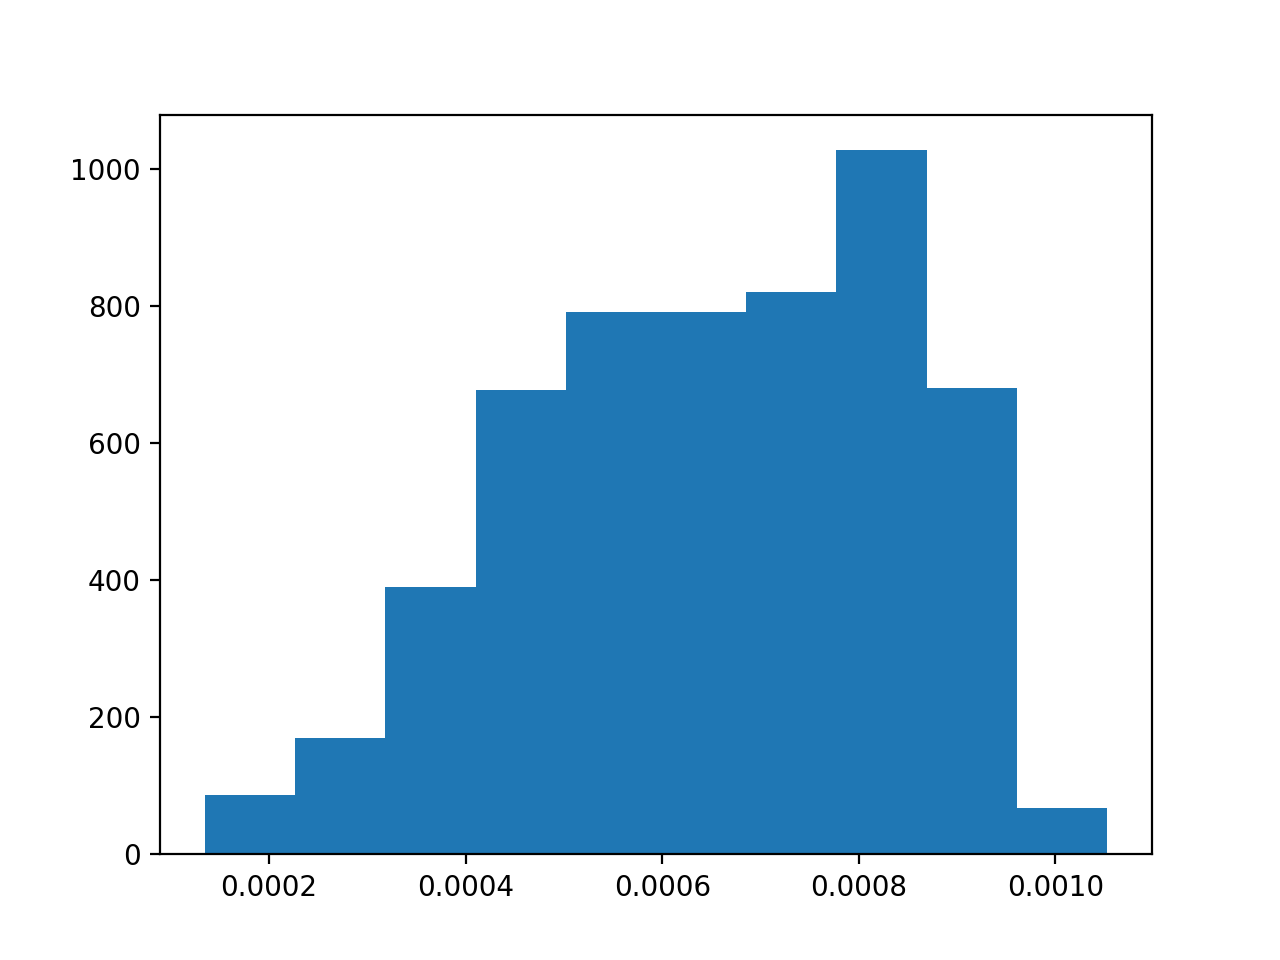

(array([  87.,  170.,  390.,  677.,  791.,  791.,  820., 1027.,  680.,
          67.]),
 array([0.000135  , 0.00022674, 0.00031847, 0.00041021, 0.00050195,
        0.00059369, 0.00068543, 0.00077716, 0.0008689 , 0.00096064,
        0.00105238]),
 <a list of 10 Patch objects>)

In [183]:
plt.figure()
plt.hist(edgeAmp)